# Performance

Plot model performance across folds. 

Uses:
1. cluster config
2. Model metrics.json

In [166]:
library(ggplot2)
library(jsonlite)
library(patchwork)
library(RColorBrewer)

In [6]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', header=T, sep='\t', stringsAsFactors = F)

cluster_config

cluster,colour,description,new_cluster
<int>,<chr>,<chr>,<int>
1,#B03743,Fibroblast,1
2,#E85F6D,Fibroblast-like,3
3,#7C2730,Fibroblast-like,2
4,#F0A118,Intermediate,12
5,#78A824,Pre-iPSC,13
6,#A6D854,Pre-iPSC,14
7,#F01D35,Fibroblast-like,5
8,#13C4A3,iPSC,15
9,#406614,Partially-reprogrammed,10


In [19]:
# for fold 0
FOLD0_PATH = "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx%d/metrics/metrics.json"

In [29]:
# for remaining folds
FOLDS_PATH = "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20230119_chrombpnet_lite_folds1_9/fold%d/chrombpnet/cluster_idx%d/metrics/metrics.json"

In [30]:
metrics = list()

for (i in 1:15) {
    metrics[[i]] = fromJSON(sprintf(FOLD0_PATH,i))
}

i=16
for (j in 1:9) {
    for (k in 1:15) {
        metrics[[i]] = fromJSON(sprintf(FOLDS_PATH,j,k))
        i = i + 1
    }
}

In [31]:
length(metrics)

[1] 150

In [185]:
metrics_df = do.call(rbind, lapply(metrics, data.frame))
metrics_df$new_cluster = cluster_config[rep(seq(15), 10), "new_cluster"]
metrics_df$fold = rep(seq(10), each=15)
rownames(metrics_df) = paste('f', metrics_df$fold, '_c', metrics_df$new_cluster, sep='')

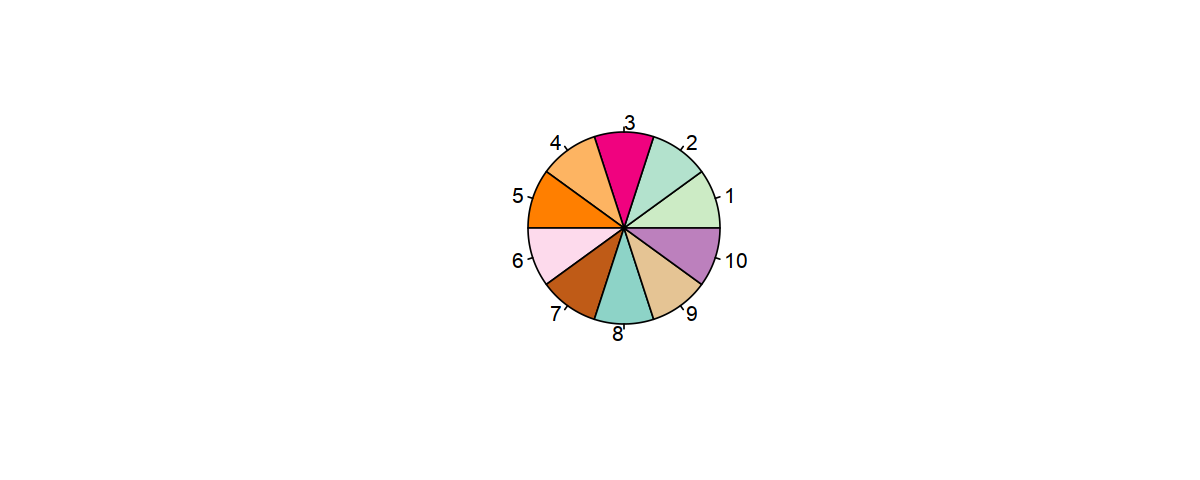

In [124]:
n <- 10
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
colors = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
pie(rep(1,n), col=sample(colors, n))

### Plot counts performance

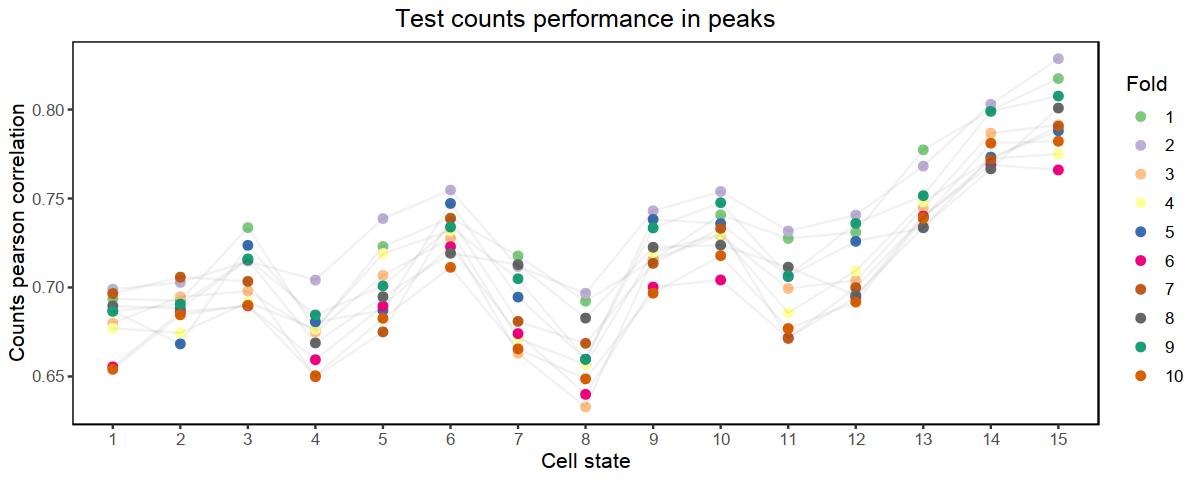

In [209]:
options(repr.plot.width = 10, repr.plot.height = 4)

cts_peaks_plot <- ggplot(metrics_df) +
geom_point(aes(x=factor(new_cluster), y=chrombpnet_cts_pearson_peaks, group=factor(fold), color=factor(fold)), size=2) + 
geom_line(aes(x=factor(new_cluster), y=chrombpnet_cts_pearson_peaks, group=factor(fold)), alpha=.05) + 
ggtitle("Test counts performance in peaks") +
xlab("Cell state") +
ylab("Counts pearson correlation") +
theme_classic() +
scale_color_manual(values=colors, name='Fold') +
theme(
    plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
#           axis.text.x=element_blank(),
#           axis.text.y=element_blank(),
#           axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5),
          legend.position = "right") 

cts_peaks_plot

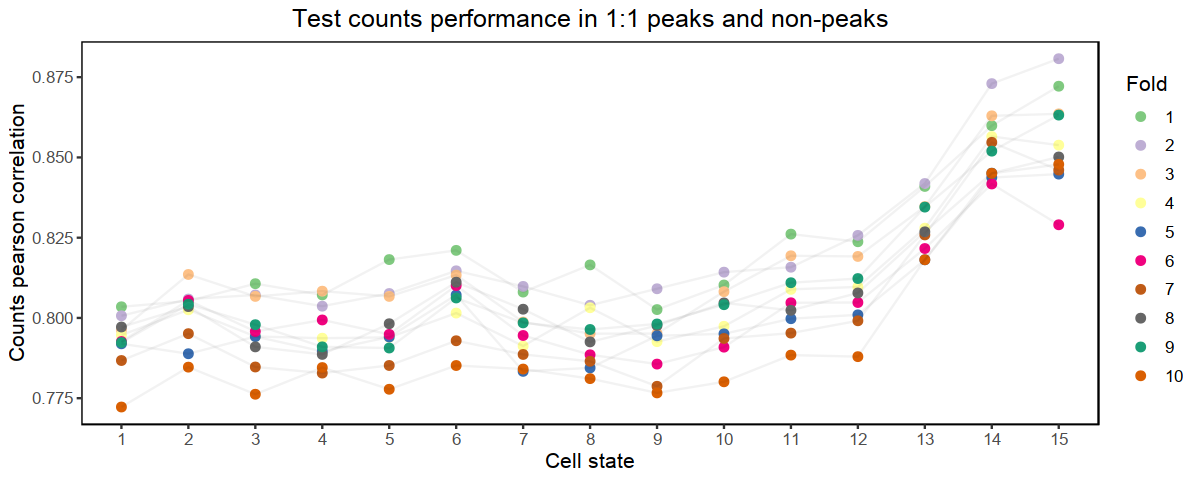

In [210]:
options(repr.plot.width = 10, repr.plot.height = 4)

cts_peaks_nonpeaks_plot <- ggplot(metrics_df) +
geom_point(aes(x=factor(new_cluster), y=chrombpnet_cts_pearson_peaks_nonpeaks, group=fold, color=factor(fold)), size=2) + 
geom_line(aes(x=factor(new_cluster), y=chrombpnet_cts_pearson_peaks_nonpeaks, group=fold), alpha=.05) + 
ggtitle("Test counts performance in 1:1 peaks and non-peaks") +
xlab("Cell state") +
ylab("Counts pearson correlation") +
theme_classic() +
scale_color_manual(values=colors, name='Fold') +
theme(
    plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
#           axis.text.x=element_blank(),
#           axis.text.y=element_blank(),
#           axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5),
          legend.position = "right") 

cts_peaks_nonpeaks_plot

### Profile performance

Pseudorep vs sample JSD baseline -- obtained by subsampling reads into half and comparing with original. 

See `Pseudorep_JSD.ipynb` for pseudosampling and computing JSD.

In [260]:
pseudorep_jsd = read.csv("./pseudorep.tsv", sep='\t')
pseudorep_jsd$new_cluster = cluster_config[pseudorep_jsd$cluster, "new_cluster"]
pseudorep_jsd = pseudorep_jsd[order(pseudorep_jsd$new_cluster), ]
rownames(pseudorep_jsd) = pseudorep_jsd$new_cluster
pseudorep_jsd

,cluster,jsd,new_cluster
,<int>,<dbl>,<int>
1,1,0.3803774,1
2,3,0.5118831,2
3,2,0.4424365,3
4,12,0.4833663,4
5,7,0.5214575,5
6,13,0.5205064,6
7,15,0.5226647,7
8,11,0.4986321,8
9,10,0.5268027,9


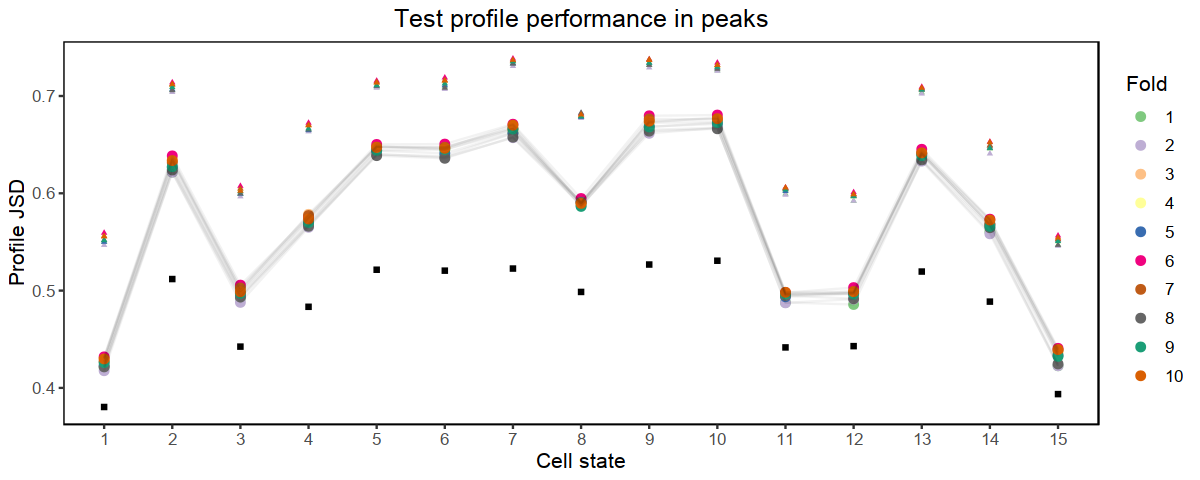

In [261]:
options(repr.plot.width = 10, repr.plot.height = 4)

profile_peaks_plot <- ggplot(metrics_df) +
geom_point(aes(x=factor(new_cluster), y=chrombpnet_profile_median_jsd_peaks, group=fold, color=factor(fold)), size=2) + 
geom_line(aes(x=factor(new_cluster), y=chrombpnet_profile_median_jsd_peaks, group=fold), alpha=.05) + 
ggtitle("Test profile performance in peaks") +
xlab("Cell state") +
ylab("Profile JSD") +
theme_classic() +
scale_color_manual(values=colors, name='Fold') +
theme(
    plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
#           axis.text.x=element_blank(),
#           axis.text.y=element_blank(),
#           axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5),
          legend.position = "right")  +
geom_point(aes(x=factor(new_cluster), y=bias_profile_median_jsd_peaks, color=factor(fold)), fill=NA, shape='triangle', size=1) +
geom_point(data=pseudorep_jsd, aes(x=factor(new_cluster), y=jsd), shape='square')

profile_peaks_plot

In [262]:
colnames(prof_metrics_df)

[1] "chrombpnet_cts_pearson_peaks_nonpeaks"         
 [2] "chrombpnet_cts_spearman_peaks_nonpeaks"        
 [3] "binary_auc"                                    
 [4] "chrombpnet_cts_pearson_peaks"                  
 [5] "chrombpnet_cts_spearman_peaks"                 
 [6] "chrombpnet_cts_pearson_peaks_wo_bias"          
 [7] "chrombpnet_cts_spearman_peaks_wo_bias"         
 [8] "bias_cts_pearson_peaks"                        
 [9] "bias_cts_spearman_peaks"                       
[10] "chrombpnet_profile_median_jsd_peaks"           
[11] "chrombpnet_profile_median_jsd_peaks_wo_bias"   
[12] "bias_profile_median_jsd_peaks"                 
[13] "chrombpnet_profile_median_jsd_peaks_randomized"
[14] "new_cluster"                                   
[15] "fold"                                          
[16] "pseudorep"                                     
[17] "norm_score"

Trying a normalized score - best bound is pseudorep and worst is bias model.

In [280]:
prof_metrics_df = metrics_df
prof_metrics_df$pseudorep = pseudorep_jsd[metrics_df$new_cluster, "jsd"]
# prof_metrics_df$norm_score = (prof_metrics_df$bias_profile_median_jsd_peaks - prof_metrics_df$chrombpnet_profile_median_jsd_peaks)/(prof_metrics_df$bias_profile_median_jsd_peaks - prof_metrics_df$pseudorep)
prof_metrics_df$norm_score = 1 - (prof_metrics_df$chrombpnet_profile_median_jsd_peaks/prof_metrics_df$bias_profile_median_jsd_peaks)

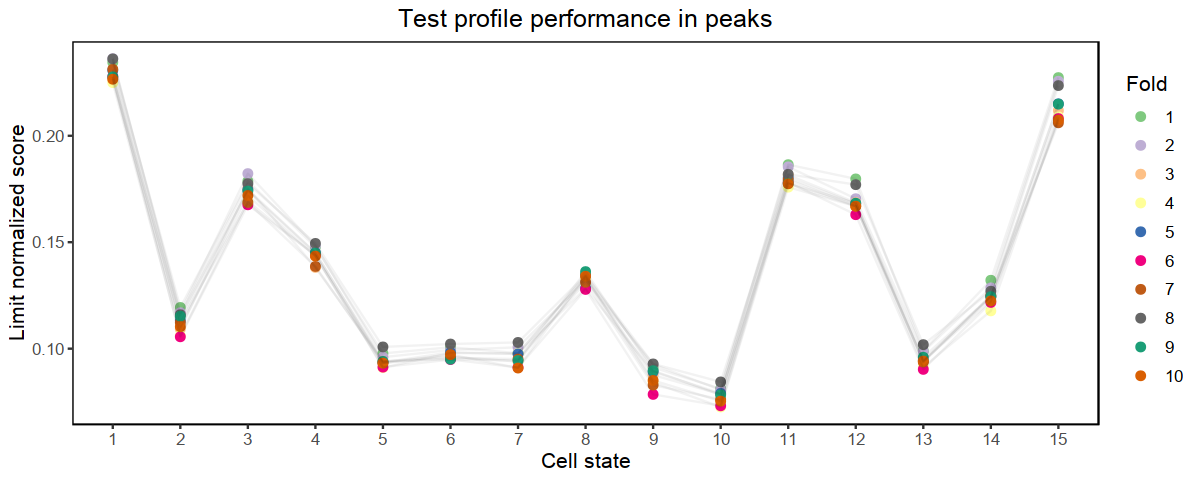

In [281]:
options(repr.plot.width = 10, repr.plot.height = 4)

norm_profile_peaks_plot <- ggplot(prof_metrics_df) +
geom_point(aes(x=factor(new_cluster), y=norm_score, group=fold, color=factor(fold)), size=2) + 
geom_line(aes(x=factor(new_cluster), y=norm_score, group=fold), alpha=.05) + 
ggtitle("Test profile performance in peaks") +
xlab("Cell state") +
ylab("Limit normalized score") +
theme_classic() +
scale_color_manual(values=colors, name='Fold') +
theme(
    plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
#           axis.text.x=element_blank(),
#           axis.text.y=element_blank(),
#           axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5),
          legend.position = "right") 

norm_profile_peaks_plot

Doesn't quite remove dependence on depth.

Explicitly show read counts in each cluster

In [265]:
cluster_cts = read.csv("./tagalign.counts.tsv", sep='\t')
cluster_cts$new_cluster = cluster_config[cluster_cts$cluster, "new_cluster"]
cluster_cts = cluster_cts[order(cluster_cts$new_cluster), ]
rownames(cluster_cts) = cluster_cts$new_cluster
cluster_cts$log10_frag_cts = log10(cluster_cts$tagalign_counts/2)
cluster_cts

,cluster,tagalign_counts,new_cluster,log10_frag_cts
,<int>,<int>,<int>,<dbl>
1,1,405673952,1,8.307147
2,3,31567014,2,7.198204
3,2,201358966,3,8.002941
4,12,81197430,4,7.608512
5,7,34954818,5,7.242477
6,13,31334896,6,7.194998
7,15,21200702,7,7.025320
8,11,67544062,8,7.528557
9,10,22522998,9,7.051596


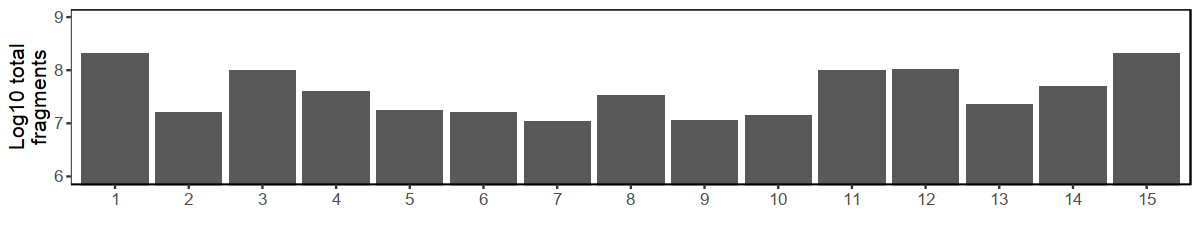

In [270]:
options(repr.plot.width = 10, repr.plot.height = 2)

cts_plot <- ggplot(cluster_cts) +
geom_bar(aes(x=factor(new_cluster), y=log10_frag_cts), stat='identity')  +
theme_classic() +
xlab("") +
ylab("Log10 total\nfragments") + 
coord_cartesian(ylim = c(6,9)) +
theme(
    plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
#           axis.text.x=element_blank(),
#           axis.text.y=element_blank(),
#           axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5),
          legend.position = "right") 

cts_plot

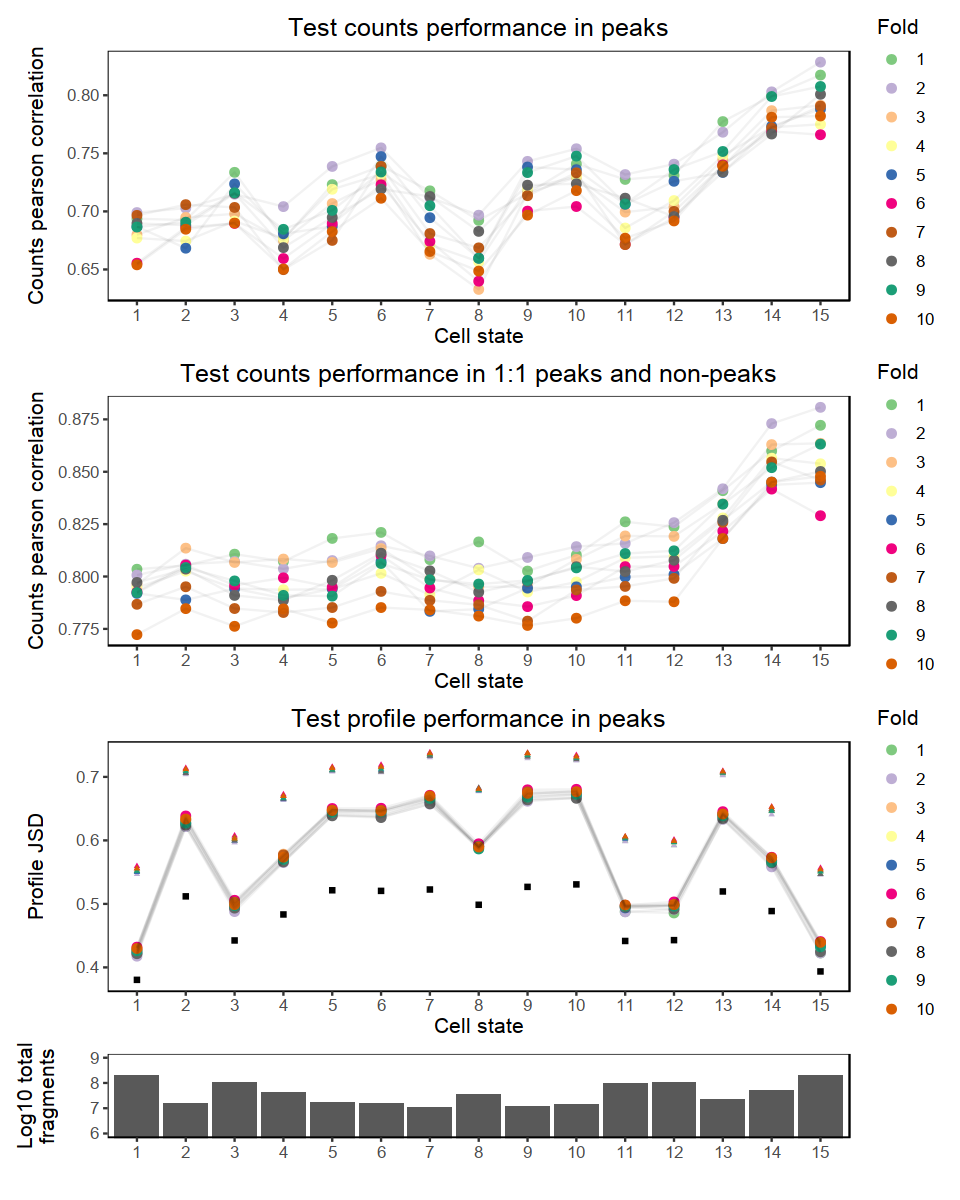

In [271]:
options(repr.plot.width = 8, repr.plot.height = 10)

all_plots <- wrap_plots(cts_peaks_plot,
           cts_peaks_nonpeaks_plot,
           profile_peaks_plot,
           cts_plot,
           heights=c(3,3,3,1))

all_plots

In [276]:
ggsave("./performance.pdf", all_plots, width=8, height=10,  useDingbats=F)